In [1]:
#importing libraries

import numpy as np
import pandas as pd
import time
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# Versions
print("PyTorch version:    ", torch.__version__)
print("CUDA available:     ", torch.cuda.is_available())
#print("Intel Optimizations:", ipex.version.__version__)

PyTorch version:     1.12.1
CUDA available:      False


In [3]:
#settings
RANDOM_SEED = 1
BATCH_SIZE = 100
NUM_EPOCHS = 100
#If the GPU is available use it for the computation otherwise use the CPU
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
#importing dataset - Pytorch torchvision contains inbuilt datasets such as MNIST, FashionMNIST, CIFAR10 etc
#It will download the dataset first time
train_dataset = datasets.FashionMNIST(
root = './data',
download = True,
train = True,
transform = transforms.Compose([transforms.ToTensor()])
)

test_dataset = datasets.FashionMNIST(
root = './data',
download = True,
train = False,
transform = transforms.Compose([transforms.ToTensor()])
)

In [5]:
#data loader - We use dataLoader class from torch.utils.data to load data in batches

train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle= True)
test_loader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle= False)

In [6]:
#checking the dataset
for images, labels in train_loader:
    print('Image batch dimension:', images.shape)
    print('Image label dimensions:', labels.shape)
    print(labels)
    break

Image batch dimension: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])
tensor([8, 9, 2, 2, 4, 9, 2, 8, 9, 4, 2, 9, 8, 1, 5, 6, 7, 2, 3, 9, 1, 4, 1, 4,
        7, 2, 9, 7, 7, 1, 3, 3, 6, 6, 7, 4, 6, 9, 5, 6, 2, 4, 1, 4, 3, 6, 5, 2,
        4, 0, 8, 7, 9, 6, 6, 2, 8, 1, 7, 7, 8, 1, 0, 0, 7, 2, 2, 5, 2, 9, 9, 3,
        1, 5, 4, 3, 3, 7, 4, 6, 4, 3, 3, 1, 8, 7, 4, 5, 0, 8, 1, 0, 8, 5, 5, 4,
        4, 7, 3, 7])


hi


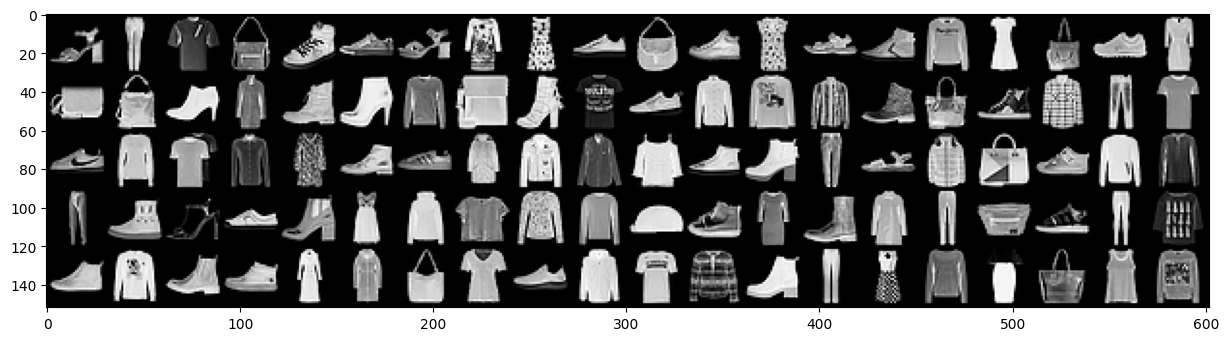

In [7]:
images, labels = next(iter(train_loader))
#used to create a grid of images
grid = torchvision.utils.make_grid(images,nrow=20)
plt.figure(figsize=(15,15))
print("hi")
plt.imshow(np.transpose(grid,(1,2,0)),cmap='gray')

In [8]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()

        self.num_classes = num_classes

        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()

        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()

    def forward(self, x):
        out = self.linear_1(x)
        out = torch.sigmoid(out)
        logits = self.linear_out(out)
        #probas = torch.softmax(logits, dim = 1)
        return logits#, probas

In [9]:
#model initialization

torch.manual_seed(RANDOM_SEED)
model = MLP(num_features= 28*28, num_hidden=100, num_classes=10)

#model = model.to(DEVICE, memory_format=torch.channels_last)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [10]:
#Training

#computing loss for each epoch
def compute_loss (net, data_loader):
    curr_loss = 0.
    with torch.no_grad(): #disabled gradient, do not build computation graph as we are computing only loss no backward
        #Iterrating over dataloader, compute loss and add it up (instead of computing on whole dataset)
        for cnt, (features, targets) in enumerate (data_loader):
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            #logits, probas = net(features)
            logits = net(features)
            #loss = F.nll_loss(torch.log(probas), targets)
            #for more numerically stable
            loss = F.cross_entropy(logits, targets)
            curr_loss += loss
        return float(curr_loss)/cnt



start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model.train()
    #model, optimizer = ipex.optimize(model, optimizer=optimizer)
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)

        #Forward and Back Prop
        #logits, probas = model(features)
        logits = model(features) #call forward

        #cost = F.nll_loss(torch.log(probas), targets)
        cost = F.cross_entropy(logits, targets) #corss entropy does log softmax
        optimizer.zero_grad() #set gradients from prev round to 0

        cost.backward() #call backward for back prop

        #Update model parameters
        optimizer.step()

        #Logging
        minibatch_cost.append(cost.item())
        if not batch_idx % 50:
            print('Epoch : %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx, len(train_loader), cost.item()))

    cost = compute_loss(model,train_loader)
    epoch_cost.append(cost)
    print('Epoch : %03d/%03d | Cost: %.4f' % (epoch+1, NUM_EPOCHS, cost))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch : 001/100 | Batch 000/600 | Cost: 2.4482
Epoch : 001/100 | Batch 050/600 | Cost: 1.5275
Epoch : 001/100 | Batch 100/600 | Cost: 1.1821
Epoch : 001/100 | Batch 150/600 | Cost: 0.9542
Epoch : 001/100 | Batch 200/600 | Cost: 0.8861
Epoch : 001/100 | Batch 250/600 | Cost: 0.7658
Epoch : 001/100 | Batch 300/600 | Cost: 0.9047
Epoch : 001/100 | Batch 350/600 | Cost: 0.7131
Epoch : 001/100 | Batch 400/600 | Cost: 0.7419
Epoch : 001/100 | Batch 450/600 | Cost: 0.5554
Epoch : 001/100 | Batch 500/600 | Cost: 0.6637
Epoch : 001/100 | Batch 550/600 | Cost: 0.7448
Epoch : 001/100 | Cost: 0.6399
Time elapsed: 0.17 min
Epoch : 002/100 | Batch 000/600 | Cost: 0.5834
Epoch : 002/100 | Batch 050/600 | Cost: 0.7684
Epoch : 002/100 | Batch 100/600 | Cost: 0.6630
Epoch : 002/100 | Batch 150/600 | Cost: 0.6103
Epoch : 002/100 | Batch 200/600 | Cost: 0.7538
Epoch : 002/100 | Batch 250/600 | Cost: 0.4955
Epoch : 002/100 | Batch 300/600 | Cost: 0.5985
Epoch : 002/100 | Batch 350/600 | Cost: 0.5482
Epoch 

Epoch : 014/100 | Batch 200/600 | Cost: 0.3224
Epoch : 014/100 | Batch 250/600 | Cost: 0.4111
Epoch : 014/100 | Batch 300/600 | Cost: 0.3930
Epoch : 014/100 | Batch 350/600 | Cost: 0.4335
Epoch : 014/100 | Batch 400/600 | Cost: 0.3617
Epoch : 014/100 | Batch 450/600 | Cost: 0.3520
Epoch : 014/100 | Batch 500/600 | Cost: 0.3943
Epoch : 014/100 | Batch 550/600 | Cost: 0.3657
Epoch : 014/100 | Cost: 0.3743
Time elapsed: 2.59 min
Epoch : 015/100 | Batch 000/600 | Cost: 0.3007
Epoch : 015/100 | Batch 050/600 | Cost: 0.3994
Epoch : 015/100 | Batch 100/600 | Cost: 0.3599
Epoch : 015/100 | Batch 150/600 | Cost: 0.3497
Epoch : 015/100 | Batch 200/600 | Cost: 0.5592
Epoch : 015/100 | Batch 250/600 | Cost: 0.4293
Epoch : 015/100 | Batch 300/600 | Cost: 0.3292
Epoch : 015/100 | Batch 350/600 | Cost: 0.5042
Epoch : 015/100 | Batch 400/600 | Cost: 0.3128
Epoch : 015/100 | Batch 450/600 | Cost: 0.6021
Epoch : 015/100 | Batch 500/600 | Cost: 0.2996
Epoch : 015/100 | Batch 550/600 | Cost: 0.3975
Epoch 

Epoch : 027/100 | Batch 400/600 | Cost: 0.3211
Epoch : 027/100 | Batch 450/600 | Cost: 0.2922
Epoch : 027/100 | Batch 500/600 | Cost: 0.3678
Epoch : 027/100 | Batch 550/600 | Cost: 0.2454
Epoch : 027/100 | Cost: 0.3269
Time elapsed: 4.89 min
Epoch : 028/100 | Batch 000/600 | Cost: 0.2356
Epoch : 028/100 | Batch 050/600 | Cost: 0.3180
Epoch : 028/100 | Batch 100/600 | Cost: 0.3037
Epoch : 028/100 | Batch 150/600 | Cost: 0.3078
Epoch : 028/100 | Batch 200/600 | Cost: 0.3147
Epoch : 028/100 | Batch 250/600 | Cost: 0.2523
Epoch : 028/100 | Batch 300/600 | Cost: 0.4647
Epoch : 028/100 | Batch 350/600 | Cost: 0.4001
Epoch : 028/100 | Batch 400/600 | Cost: 0.4109
Epoch : 028/100 | Batch 450/600 | Cost: 0.2383
Epoch : 028/100 | Batch 500/600 | Cost: 0.4487
Epoch : 028/100 | Batch 550/600 | Cost: 0.3486
Epoch : 028/100 | Cost: 0.3235
Time elapsed: 5.06 min
Epoch : 029/100 | Batch 000/600 | Cost: 0.3605
Epoch : 029/100 | Batch 050/600 | Cost: 0.2733
Epoch : 029/100 | Batch 100/600 | Cost: 0.2225

Epoch : 040/100 | Cost: 0.2974
Time elapsed: 7.12 min
Epoch : 041/100 | Batch 000/600 | Cost: 0.3892
Epoch : 041/100 | Batch 050/600 | Cost: 0.2218
Epoch : 041/100 | Batch 100/600 | Cost: 0.3670
Epoch : 041/100 | Batch 150/600 | Cost: 0.2971
Epoch : 041/100 | Batch 200/600 | Cost: 0.3816
Epoch : 041/100 | Batch 250/600 | Cost: 0.3597
Epoch : 041/100 | Batch 300/600 | Cost: 0.2996
Epoch : 041/100 | Batch 350/600 | Cost: 0.1924
Epoch : 041/100 | Batch 400/600 | Cost: 0.4000
Epoch : 041/100 | Batch 450/600 | Cost: 0.2805
Epoch : 041/100 | Batch 500/600 | Cost: 0.2599
Epoch : 041/100 | Batch 550/600 | Cost: 0.2436
Epoch : 041/100 | Cost: 0.2970
Time elapsed: 7.29 min
Epoch : 042/100 | Batch 000/600 | Cost: 0.3370
Epoch : 042/100 | Batch 050/600 | Cost: 0.2600
Epoch : 042/100 | Batch 100/600 | Cost: 0.1915
Epoch : 042/100 | Batch 150/600 | Cost: 0.2950
Epoch : 042/100 | Batch 200/600 | Cost: 0.2613
Epoch : 042/100 | Batch 250/600 | Cost: 0.2748
Epoch : 042/100 | Batch 300/600 | Cost: 0.2314

Epoch : 054/100 | Batch 150/600 | Cost: 0.3265
Epoch : 054/100 | Batch 200/600 | Cost: 0.3549
Epoch : 054/100 | Batch 250/600 | Cost: 0.1922
Epoch : 054/100 | Batch 300/600 | Cost: 0.2331
Epoch : 054/100 | Batch 350/600 | Cost: 0.2161
Epoch : 054/100 | Batch 400/600 | Cost: 0.3008
Epoch : 054/100 | Batch 450/600 | Cost: 0.2461
Epoch : 054/100 | Batch 500/600 | Cost: 0.2142
Epoch : 054/100 | Batch 550/600 | Cost: 0.2477
Epoch : 054/100 | Cost: 0.2728
Time elapsed: 9.67 min
Epoch : 055/100 | Batch 000/600 | Cost: 0.2420
Epoch : 055/100 | Batch 050/600 | Cost: 0.3101
Epoch : 055/100 | Batch 100/600 | Cost: 0.4517
Epoch : 055/100 | Batch 150/600 | Cost: 0.2484
Epoch : 055/100 | Batch 200/600 | Cost: 0.2973
Epoch : 055/100 | Batch 250/600 | Cost: 0.3569
Epoch : 055/100 | Batch 300/600 | Cost: 0.2827
Epoch : 055/100 | Batch 350/600 | Cost: 0.3014
Epoch : 055/100 | Batch 400/600 | Cost: 0.2113
Epoch : 055/100 | Batch 450/600 | Cost: 0.2539
Epoch : 055/100 | Batch 500/600 | Cost: 0.2895
Epoch 

Epoch : 067/100 | Batch 350/600 | Cost: 0.2983
Epoch : 067/100 | Batch 400/600 | Cost: 0.2849
Epoch : 067/100 | Batch 450/600 | Cost: 0.3380
Epoch : 067/100 | Batch 500/600 | Cost: 0.2464
Epoch : 067/100 | Batch 550/600 | Cost: 0.2452
Epoch : 067/100 | Cost: 0.2535
Time elapsed: 11.94 min
Epoch : 068/100 | Batch 000/600 | Cost: 0.2343
Epoch : 068/100 | Batch 050/600 | Cost: 0.2326
Epoch : 068/100 | Batch 100/600 | Cost: 0.2839
Epoch : 068/100 | Batch 150/600 | Cost: 0.2717
Epoch : 068/100 | Batch 200/600 | Cost: 0.2983
Epoch : 068/100 | Batch 250/600 | Cost: 0.1883
Epoch : 068/100 | Batch 300/600 | Cost: 0.2310
Epoch : 068/100 | Batch 350/600 | Cost: 0.1885
Epoch : 068/100 | Batch 400/600 | Cost: 0.2812
Epoch : 068/100 | Batch 450/600 | Cost: 0.1892
Epoch : 068/100 | Batch 500/600 | Cost: 0.3166
Epoch : 068/100 | Batch 550/600 | Cost: 0.3082
Epoch : 068/100 | Cost: 0.2535
Time elapsed: 12.11 min
Epoch : 069/100 | Batch 000/600 | Cost: 0.2681
Epoch : 069/100 | Batch 050/600 | Cost: 0.33

Epoch : 080/100 | Batch 550/600 | Cost: 0.2354
Epoch : 080/100 | Cost: 0.2385
Time elapsed: 14.21 min
Epoch : 081/100 | Batch 000/600 | Cost: 0.2439
Epoch : 081/100 | Batch 050/600 | Cost: 0.1783
Epoch : 081/100 | Batch 100/600 | Cost: 0.2879
Epoch : 081/100 | Batch 150/600 | Cost: 0.2336
Epoch : 081/100 | Batch 200/600 | Cost: 0.1512
Epoch : 081/100 | Batch 250/600 | Cost: 0.1547
Epoch : 081/100 | Batch 300/600 | Cost: 0.2065
Epoch : 081/100 | Batch 350/600 | Cost: 0.2754
Epoch : 081/100 | Batch 400/600 | Cost: 0.2522
Epoch : 081/100 | Batch 450/600 | Cost: 0.1365
Epoch : 081/100 | Batch 500/600 | Cost: 0.2390
Epoch : 081/100 | Batch 550/600 | Cost: 0.2240
Epoch : 081/100 | Cost: 0.2427
Time elapsed: 14.40 min
Epoch : 082/100 | Batch 000/600 | Cost: 0.2366
Epoch : 082/100 | Batch 050/600 | Cost: 0.1418
Epoch : 082/100 | Batch 100/600 | Cost: 0.2866
Epoch : 082/100 | Batch 150/600 | Cost: 0.2466
Epoch : 082/100 | Batch 200/600 | Cost: 0.2319
Epoch : 082/100 | Batch 250/600 | Cost: 0.27

Epoch : 094/100 | Batch 050/600 | Cost: 0.2171
Epoch : 094/100 | Batch 100/600 | Cost: 0.1598
Epoch : 094/100 | Batch 150/600 | Cost: 0.2360
Epoch : 094/100 | Batch 200/600 | Cost: 0.1801
Epoch : 094/100 | Batch 250/600 | Cost: 0.1898
Epoch : 094/100 | Batch 300/600 | Cost: 0.2189
Epoch : 094/100 | Batch 350/600 | Cost: 0.1932
Epoch : 094/100 | Batch 400/600 | Cost: 0.2559
Epoch : 094/100 | Batch 450/600 | Cost: 0.3235
Epoch : 094/100 | Batch 500/600 | Cost: 0.2615
Epoch : 094/100 | Batch 550/600 | Cost: 0.3321
Epoch : 094/100 | Cost: 0.2303
Time elapsed: 16.79 min
Epoch : 095/100 | Batch 000/600 | Cost: 0.2421
Epoch : 095/100 | Batch 050/600 | Cost: 0.2863
Epoch : 095/100 | Batch 100/600 | Cost: 0.2906
Epoch : 095/100 | Batch 150/600 | Cost: 0.2917
Epoch : 095/100 | Batch 200/600 | Cost: 0.3095
Epoch : 095/100 | Batch 250/600 | Cost: 0.1617
Epoch : 095/100 | Batch 300/600 | Cost: 0.2405
Epoch : 095/100 | Batch 350/600 | Cost: 0.1810
Epoch : 095/100 | Batch 400/600 | Cost: 0.1946
Epoch

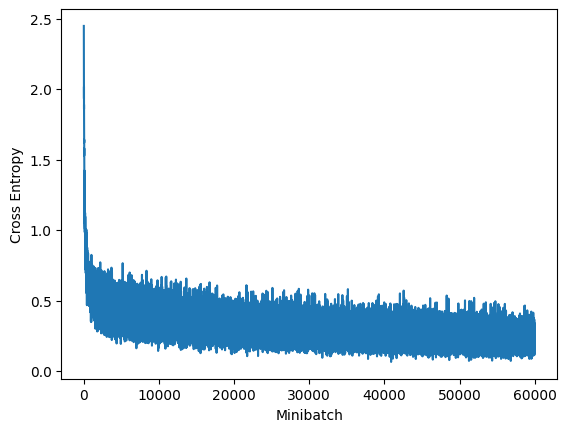

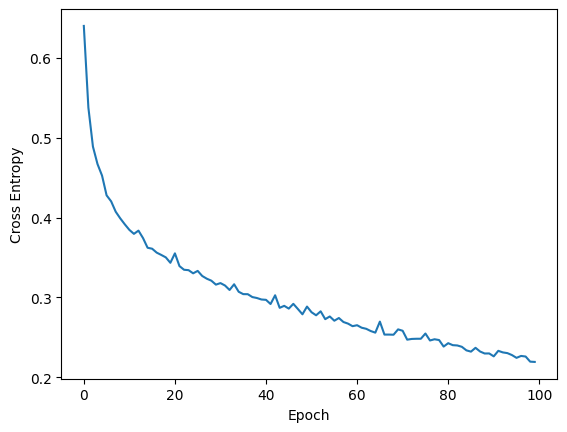

In [11]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [12]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 92.15
Test Accuracy: 88.23


In [13]:
model.linear_1.bias

Parameter containing:
tensor([ 1.4389e-01,  1.4299e-01,  1.9938e-02,  4.7564e-02, -2.0399e-01,
         7.4462e-02, -1.5249e-01,  7.9738e-02, -1.5479e-01,  4.3484e-01,
        -2.6198e-02,  1.6762e-01, -2.0110e-02, -4.0242e-01,  1.9872e-01,
         6.6440e-02,  2.2505e-01, -5.7852e-02, -2.2669e-02, -2.3433e-01,
        -4.7133e-02,  1.4179e-01, -7.9046e-02,  1.3502e-01, -9.0669e-02,
         4.8952e-02,  9.7117e-02,  9.0284e-02, -1.5277e-01, -1.9743e-01,
        -5.3189e-02,  5.1181e-02,  1.7805e-01, -2.1274e-01,  1.9441e-01,
        -1.6286e-02, -1.1084e-01,  1.8409e-01,  2.2581e-01,  5.9910e-04,
         1.5107e-01, -3.2668e-01,  1.0608e-01,  1.2056e-01,  1.3749e-01,
        -1.1258e-01,  6.8028e-02,  9.4676e-02,  3.3950e-01,  1.2449e-01,
        -1.3477e-01, -5.6085e-01,  3.8815e-02, -5.2731e-02,  2.4965e-01,
         5.0577e-01, -4.1300e-01, -1.3065e-01,  8.3011e-02, -8.6956e-02,
        -2.7272e-01,  1.6842e-02, -6.3485e-02, -1.7913e-01,  1.5856e-01,
        -2.4373e-02,  6.5090e

In [14]:
model.linear_1.weight

Parameter containing:
tensor([[-6.6186e-02,  1.2960e-01, -8.8252e-02,  ..., -1.5946e-01,
         -7.0718e-02, -1.9098e-01],
        [ 1.8621e-01,  2.0218e-06,  1.1295e-01,  ..., -1.5281e-01,
         -2.1770e-01, -4.7607e-02],
        [ 6.9112e-02, -1.1923e-01, -1.2154e-02,  ...,  3.8520e-02,
          1.9385e-01,  1.2205e-01],
        ...,
        [-9.8175e-03,  2.3360e-01, -1.2281e-01,  ..., -3.9521e-02,
          1.6552e-01, -3.4329e-02],
        [ 7.4514e-02, -1.0441e-01,  4.5822e-02,  ...,  3.9643e-02,
          8.1231e-02, -5.7390e-02],
        [-5.2604e-02, -1.0427e-01, -1.3513e-02,  ...,  7.3404e-02,
          3.7709e-02,  9.2471e-02]], requires_grad=True)

In [15]:
with open("output/mlp_l1_weights.npy", "wb") as f:
    np.save(f, model.linear_1.weight.detach().numpy(), False)
with open("output/mlp_l1_bias.npy", "wb") as f:
    np.save(f, model.linear_1.bias.detach().numpy(), False)
with open("output/mlp_l2_weights.npy", "wb") as f:
    np.save(f, model.linear_out.weight.detach().numpy(), False)
with open("output/mlp_l2_bias.npy", "wb") as f:
    np.save(f, model.linear_out.bias.detach().numpy(), False)

In [27]:
torch.save(model, "output/saved_mlp_model.pt")

In [17]:
img,label = train_dataset[0]
print (label)

9


In [18]:
print(img.shape)

torch.Size([1, 28, 28])


In [19]:
out = model(img.reshape(-1,28*28))
_, indices = torch.sort(out, descending=True)

In [20]:
for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
        print(features.shape)
        break

torch.Size([100, 784])


In [21]:
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

In [22]:
percentage

tensor([9.6890e-06, 1.0090e-05, 4.8782e-06, 1.7643e-05, 3.9279e-06, 2.0411e-01,
        2.0384e-03, 1.0801e+00, 4.5570e-04, 9.8713e+01],
       grad_fn=<MulBackward0>)

In [23]:
out

tensor([[-4.4110, -4.3704, -5.0972, -3.8116, -5.3138,  5.5445,  0.9380,  7.2106,
         -0.5601, 11.7258]], grad_fn=<AddmmBackward0>)

In [24]:
torch.argmax(out)

tensor(9)